# EM casing response dipole source

In [1]:
import numpy as np
import os
import scipy.sparse as sp
import pandas as pd
from scipy.constants import mu_0
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize
from matplotlib import cm as colormap
import time
from string import ascii_lowercase
import pickle
from multiprocessing import Pool

# SimPEG, discretize/
import discretize
from discretize import utils
from simpeg.electromagnetics import frequency_domain as fdem
from simpeg import(
    maps, Report, data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils
)
from pymatsolver import Pardiso

from utils import pad_for_casing_and_data

In [2]:
from matplotlib import rcParams
rcParams["font.size"] = 16

In [3]:
directory_path = "/t40array/lheagy/upscaling-casing-conductivity-length"

In [4]:
def ensure_directory_exists(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directory '{directory_path}' created.")
    else:
        print(f"Directory '{directory_path}' already exists.")

# Example usage
ensure_directory_exists(directory_path)

Directory '/t40array/lheagy/upscaling-casing-conductivity-length' already exists.


In [5]:
save_figures = False
fig_dir_high = "figures"
fig_dir_low = "low-rez-figures"

dpi_high=400
dpi_low=150

## Simulation parameters

In [6]:
# # conductivities
sigma_air = 1e-4
sigma_back = 1e-1
casing_l = np.r_[10, 25, 50, 100, 250, 500, 1000]
sigma_casing = 5e6 # np.r_[5e5, 1e6, 5e6, 1e7]
mur_casing = np.r_[1, 100]

# # casing geometry
casing_b = 5e-2  
casing_t = 1e-2 #np.r_[5e-3, 7.5e-3, 10e-3, 12.5e-3, 15e-3, 20e-3]
casing_a = casing_b - casing_t

In [7]:
src_dz = 10
src_z = -1*(casing_l+10+src_dz/2)

In [8]:
keys = [f"casing_{sigma_casing:1.0e}_{mur:1.0f}_{l:1.0f}" for mur in mur_casing for l in casing_l]
keys

['casing_5e+06_1_10',
 'casing_5e+06_1_25',
 'casing_5e+06_1_50',
 'casing_5e+06_1_100',
 'casing_5e+06_1_250',
 'casing_5e+06_1_500',
 'casing_5e+06_1_1000',
 'casing_5e+06_100_10',
 'casing_5e+06_100_25',
 'casing_5e+06_100_50',
 'casing_5e+06_100_100',
 'casing_5e+06_100_250',
 'casing_5e+06_100_500',
 'casing_5e+06_100_1000']

In [9]:
# generate a mesh
hx = pad_for_casing_and_data(
   casing_outer_radius = casing_b,
    csx1 = casing_t/4, 
    csx2 = 25, 
    pfx1 = 1.3,
    pfx2 = 1.5, 
    domain_x = 1000, 
    npadx = 10
)

pfz = 1.3


meshes = {}

for i, l in enumerate(casing_l): 
    
    csz = np.min([casing_l[i]/10, 1])
    n_core_extra = int(np.ceil(10/csz))

    if csz < 0.5: 
        npad_z = 32
    elif csz < 1:
        npad_z = 30
    else:
        npad_z = 28
    
    ncore_z = int(np.max(np.r_[np.abs(casing_l[i]), np.abs(src_z[i])]) / csz) + n_core_extra
    hz = discretize.utils.unpack_widths(
        [(csz, npad_z, -pfz), (csz, ncore_z), (csz, npad_z, pfz)]
    )
    meshes[l] = discretize.CylindricalMesh(
        [hx, np.r_[2*np.pi], hz], origin=np.r_[0, 0, -np.sum(hz[:npad_z + int(ncore_z)])],
    )
    

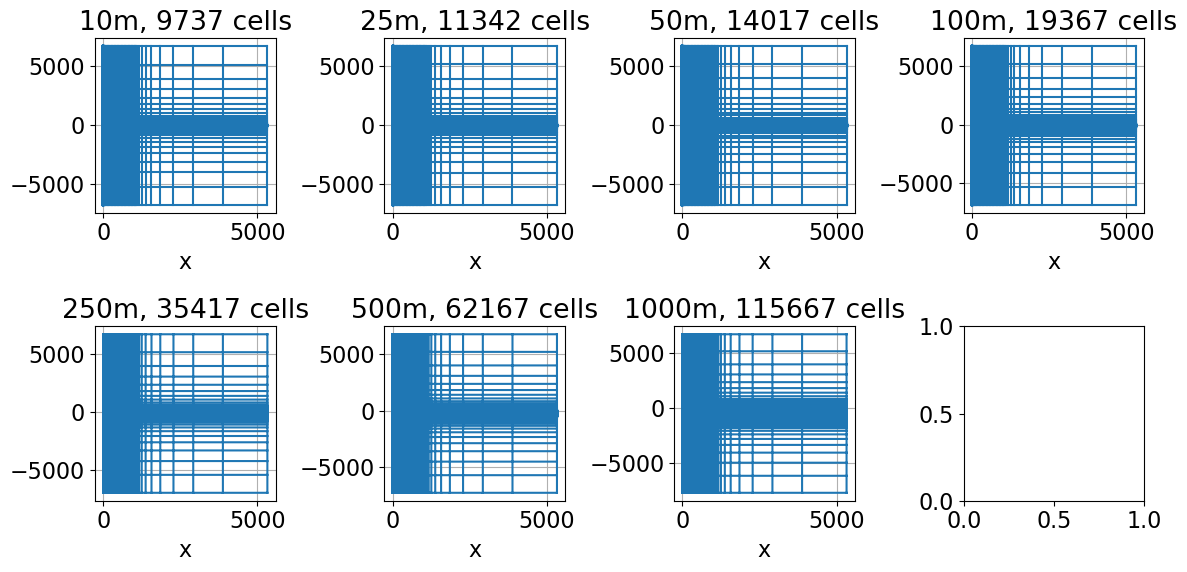

In [10]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

ax=ax.flatten()

for i, key in enumerate(meshes.keys()): 
    meshes[key].plot_grid(ax=ax[i])
    ax[i].set_ylabel("")
    ax[i].set_title(f"{casing_l[i]}m, {meshes[key].n_cells} cells")
    # ax[i].set_xlim([0, 5])
    # ax[i].set_ylim(-50, 10)
plt.tight_layout()
# ax.set_xlim([0, 5])


In [11]:
def get_physical_property_model(mesh, casing_a, casing_b, casing_l, sigma_back, sigma_casing, sigma_air=1e-4, mur_casing=1):

    model = np.ones(mesh.n_cells)*sigma_air
    model[mesh.cell_centers[:, 2] < 0] = sigma_back

    mur = np.ones(mesh.n_cells)

    inds_casing_x = (
        (mesh.cell_centers[:, 0] > casing_a) & 
        (mesh.cell_centers[:, 0] < casing_b)
    )
    inds_casing_z = (
        (mesh.cell_centers[:, 2] < 0) &
        (mesh.cell_centers[:, 2] > -casing_l)
    )
    inds_casing = inds_casing_x & inds_casing_z

    model[inds_casing] = sigma_casing
    mur[inds_casing] = mur_casing

    return model, mur

    

In [12]:
def get_lind_by_key(key):
    return np.where(casing_l == float(key.split("_")[-1]))[0][0]

In [13]:
get_lind_by_key(keys[7])

0

In [14]:
def get_l_by_key(key):
    return float(key.split("_")[-1])

In [15]:
def get_mur_by_key(key):
    return float(key.split("_")[-2])

In [16]:
sigma_back

0.1

In [17]:
models = {}
# for sig in sigma_casing:
#     for mur in mur_casing:
sig = sigma_casing

for i, key in enumerate(keys):
    mur = get_mur_by_key(key)
    sig_model, mur_model = get_physical_property_model(meshes[get_l_by_key(key)], casing_a, casing_b, get_l_by_key(key), sigma_back, sig, sigma_air=sigma_air, mur_casing=mur)
    models[key] = {
        "sigma": sig_model, 
        "mur": mur_model
    }

In [18]:
def plot_casing(mesh, model, xlim=None, zlim=None, vmin=None, vmax=None, ax=None, cb_label=None): 
    if ax is None: 
        fig, ax = plt.subplots(1, 1)
    pcolor_opts={"norm":LogNorm(vmin=vmin, vmax=vmax), "cmap":"Spectral_r"}
    out = mesh.plot_image(
        model, pcolor_opts=pcolor_opts, ax=ax, mirror=True
    )

    cb = plt.colorbar(out[-1])
    cb.set_label(cb_label)

    if xlim is not None: 
        ax.set_xlim(xlim)
    if zlim is not None: 
        ax.set_ylim(zlim)

    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    return ax

IndexError: index 12 is out of bounds for axis 0 with size 12

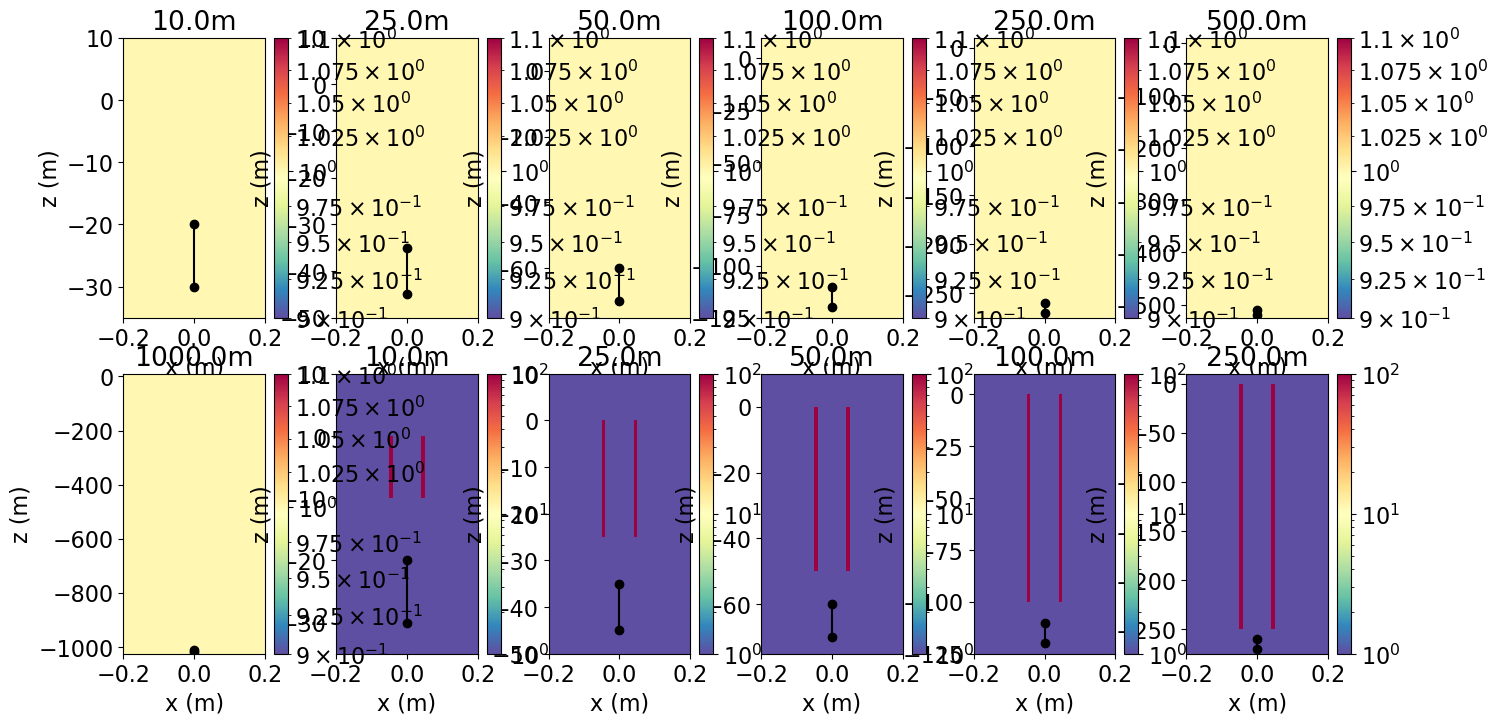

In [19]:
plot_keys = keys
fig, ax = plt.subplots(2, 6, figsize=(16, 8))
ax = ax.flatten()

xlim = 0.2*np.r_[-1, 1]
zlim = np.r_[-2500, 10]
vmin = None #1e-4 # sigma_air
vmax = None# np.max(sigma_casing)

for i, key in enumerate(plot_keys):
    zlim = np.r_[-1*(get_l_by_key(key)+25), 10]
    plot_casing(meshes[get_l_by_key(key)], models[key]["mur"], xlim=xlim, zlim=zlim, vmin=vmin, vmax=vmax, ax=ax[i])
    ax[i].set_title(f"{get_l_by_key(key)}m")
    ax[i].plot(np.r_[0, 0], src_z[get_lind_by_key(key)] + src_dz/2 * np.r_[-1, 1], "-ok")


plt.tight_layout()
# for loc in src_z:
#     ax.plot(np.r_[0, 0], loc + src_dz/2*np.r_[-1, 1], "-k", lw=4, alpha=0.5)

## set up the simulations

In [20]:
frequencies = 10**np.linspace(-1, 4, 36)
frequencies

array([1.00000000e-01, 1.38949549e-01, 1.93069773e-01, 2.68269580e-01,
       3.72759372e-01, 5.17947468e-01, 7.19685673e-01, 1.00000000e+00,
       1.38949549e+00, 1.93069773e+00, 2.68269580e+00, 3.72759372e+00,
       5.17947468e+00, 7.19685673e+00, 1.00000000e+01, 1.38949549e+01,
       1.93069773e+01, 2.68269580e+01, 3.72759372e+01, 5.17947468e+01,
       7.19685673e+01, 1.00000000e+02, 1.38949549e+02, 1.93069773e+02,
       2.68269580e+02, 3.72759372e+02, 5.17947468e+02, 7.19685673e+02,
       1.00000000e+03, 1.38949549e+03, 1.93069773e+03, 2.68269580e+03,
       3.72759372e+03, 5.17947468e+03, 7.19685673e+03, 1.00000000e+04])

In [21]:
surveys = {}
simulations = {}

for i, key in enumerate(keys): 
    src_list = []
    src_locations = np.array([
        [0, 0, src_z[get_lind_by_key(key)]+src_dz/2.],
        [0, 0, src_z[get_lind_by_key(key)]-src_dz/2.]
    ])
    for f in frequencies: 
        src = fdem.sources.LineCurrent([], location=src_locations, frequency=f)
        src_list.append(src)
        
    surveys[key] = fdem.Survey(src_list)
    simulations[key] = fdem.simulation.Simulation3DMagneticField(
        mesh=meshes[get_l_by_key(key)], sigmaMap=maps.IdentityMap(meshes[get_l_by_key(key)]),
        survey=surveys[key], solver=Pardiso, mu=models[key]["mur"]*mu_0
    #     verbose=True
    )

In [22]:
def run_simulation(key):
    
    filename = os.path.sep.join([directory_path, key])

    t = time.time()
    print(f"starting {key}..., saving to {filename}")
    fields = simulations[key].fields(models[key]["sigma"])
    print(f" ... done. {time.time()-t:1.2e} \n")
    
    np.save(filename, fields[:, "hSolution"])

    return fields

In [23]:
fields = {}

In [24]:
for key in keys: 
    if key not in fields: 
        fields[key] = run_simulation(key)

starting casing_5e+06_1_10..., saving to /t40array/lheagy/upscaling-casing-conductivity-length/casing_5e+06_1_10
 ... done. 1.89e+00 

starting casing_5e+06_1_25..., saving to /t40array/lheagy/upscaling-casing-conductivity-length/casing_5e+06_1_25
 ... done. 1.69e+00 

starting casing_5e+06_1_50..., saving to /t40array/lheagy/upscaling-casing-conductivity-length/casing_5e+06_1_50
 ... done. 2.31e+00 

starting casing_5e+06_1_100..., saving to /t40array/lheagy/upscaling-casing-conductivity-length/casing_5e+06_1_100
 ... done. 2.87e+00 

starting casing_5e+06_1_250..., saving to /t40array/lheagy/upscaling-casing-conductivity-length/casing_5e+06_1_250
 ... done. 5.12e+00 

starting casing_5e+06_1_500..., saving to /t40array/lheagy/upscaling-casing-conductivity-length/casing_5e+06_1_500
 ... done. 8.91e+00 

starting casing_5e+06_1_1000..., saving to /t40array/lheagy/upscaling-casing-conductivity-length/casing_5e+06_1_1000
 ... done. 1.61e+01 

starting casing_5e+06_100_10..., saving to /t

In [25]:
fields

{'casing_5e+06_1_10': <simpeg.electromagnetics.frequency_domain.fields.Fields3DMagneticField at 0x7f7912bd3410>,
 'casing_5e+06_1_25': <simpeg.electromagnetics.frequency_domain.fields.Fields3DMagneticField at 0x7f7911df4310>,
 'casing_5e+06_1_50': <simpeg.electromagnetics.frequency_domain.fields.Fields3DMagneticField at 0x7f79210ddc50>,
 'casing_5e+06_1_100': <simpeg.electromagnetics.frequency_domain.fields.Fields3DMagneticField at 0x7f7920d28e50>,
 'casing_5e+06_1_250': <simpeg.electromagnetics.frequency_domain.fields.Fields3DMagneticField at 0x7f7920cc0290>,
 'casing_5e+06_1_500': <simpeg.electromagnetics.frequency_domain.fields.Fields3DMagneticField at 0x7f7920d4fd90>,
 'casing_5e+06_1_1000': <simpeg.electromagnetics.frequency_domain.fields.Fields3DMagneticField at 0x7f7920e6dc10>,
 'casing_5e+06_100_10': <simpeg.electromagnetics.frequency_domain.fields.Fields3DMagneticField at 0x7f7920d3b410>,
 'casing_5e+06_100_25': <simpeg.electromagnetics.frequency_domain.fields.Fields3DMagnetic

In [26]:
def skin_depth(freq, sig=sigma_casing, mur=1):
    return 1/np.sqrt(np.pi * freq * sig * mur * mu_0)

In [27]:
alpha = np.sqrt(sigma_back/(sigma_casing*np.pi*(casing_b**2 - casing_a**2)))

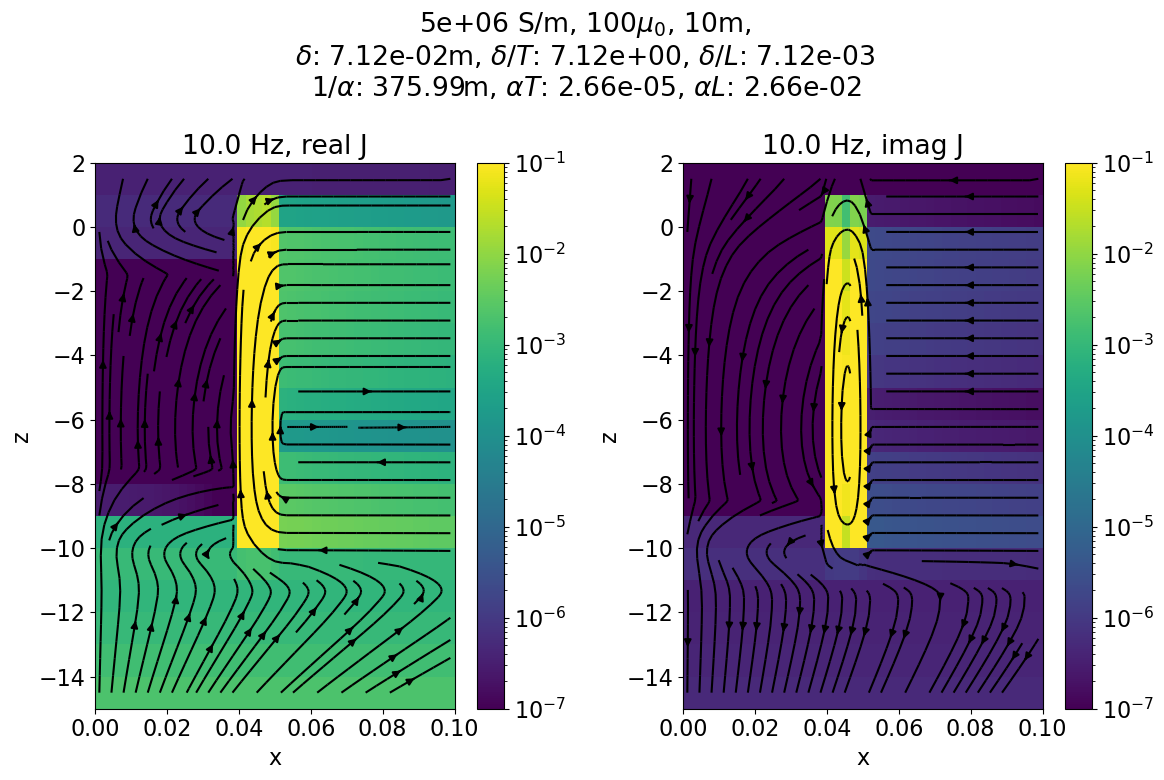

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

key_ind = 7
key = keys[key_ind]
lind = get_lind_by_key(key)
freq_ind = 14
xlim = 0.1*np.r_[0, 1]
zlim = np.r_[-casing_l[lind]-5, 2]

field_plot = (meshes[get_l_by_key(key)].average_face_to_cell_vector * fields[key][simulations[key].survey.source_list[freq_ind], "j"])

for i, component in enumerate(["real", "imag"]): 
    out = meshes[get_l_by_key(key)].plot_image(
        getattr(field_plot, component), "CCv", view="vec", 
        range_x = xlim, range_y = zlim,
        # sample_grid = np.r_[10, 10],
        mirror=True, #mirror_data=field_mirror,
        ax=ax[i], 
        pcolor_opts={"norm":LogNorm(vmin=1e-7, vmax=1e-1)}
    )
    cb = plt.colorbar(out[0], ax=ax[i])
    # cb.set_label("Electric Field (V/m)")
    # ax[i].set_aspect(1)
    ax[i].set_title(f"{frequencies[freq_ind]} Hz, {component} J")

delta = skin_depth(frequencies[freq_ind])
fig.suptitle(
    f"{key.split('_')[1]} S/m, {key.split('_')[2]}$\mu_0$, {key.split('_')[-1]}m, \n" +
    f"$\delta$: {delta:1.2e}m, $\delta/T$: {delta/casing_t:1.2e}, $\delta/L$: {delta/casing_l[lind]:1.2e} \n" +
    f"$1/\\alpha$: {1/alpha:1.2f}m, $\\alpha T$: {alpha * casing_t:1.2e}, $\\alpha L$: {alpha * casing_l[lind]:1.2e}"
    # f"$\delta$: {delta:1.2e}m, $1/\\alpha$: {1/alpha:1.2f}m, \n"
)
plt.tight_layout()

In [29]:
# def load_fields(name, conductivity, mur):
#     solution = np.load(f"{directory}/fields_{name}.npy")
#     sim = generate_simulation(mur)
#     sim.model = conductivity
#     f = sim.fieldsPair(sim)
#     f[:, sim._solutionType] = solution
#     return f

In [30]:
len(frequencies)

36

In [31]:
# casing_t_inv = np.r_[5e-3]
# mur_inv = np.r_[1, 50, 100, 150, 200]
# freq_inds_inv = np.arange(0, 31, 1)
# src_ind_inv = 5

# inv_keys = []
# for t in casing_t_inv:
#     for mur in mur_inv:
#         inv_keys.append(f"casing_{mur}_{t:1.2e}")
# inv_keys

In [32]:
# frequencies[freq_inds_inv]

In [33]:
# fields = {}
# for key in inv_keys:
#     # if key not in fields.keys():
#     fields[key] = load_fields(key, models[key]["sigma"], models[key]["mur"])

In [34]:
rcParams["font.size"] = 12

In [35]:
fields.keys()

dict_keys(['casing_5e+06_1_10', 'casing_5e+06_1_25', 'casing_5e+06_1_50', 'casing_5e+06_1_100', 'casing_5e+06_1_250', 'casing_5e+06_1_500', 'casing_5e+06_1_1000', 'casing_5e+06_100_10', 'casing_5e+06_100_25', 'casing_5e+06_100_50', 'casing_5e+06_100_100', 'casing_5e+06_100_250', 'casing_5e+06_100_500', 'casing_5e+06_100_1000'])

In [36]:
def skin_depth(f, sigma, mur):
    return np.sqrt(2/(2*np.pi*f*sigma*mur*mu_0))

In [45]:
rx_x = np.linspace(25, 500, 20)
rx_z = np.r_[-csz/2] #-np.linspace(0, 600, 25) - csz/2
rx_x

array([ 25.,  50.,  75., 100., 125., 150., 175., 200., 225., 250., 275.,
       300., 325., 350., 375., 400., 425., 450., 475., 500.])

In [46]:
def create_receivers():
    rx_ex_re = fdem.receivers.PointElectricField(
        locations=discretize.utils.ndgrid(rx_x, np.r_[0], rx_z),
        orientation="x",
        component="real",
    )
    rx_ex_im = fdem.receivers.PointElectricField(
        locations=discretize.utils.ndgrid(rx_x, np.r_[0], rx_z),
        orientation="x",
        component="imag",
    )
    rx_ez_re = fdem.receivers.PointElectricField(
        locations=discretize.utils.ndgrid(rx_x, np.r_[0], rx_z),
        orientation="z",
        component="real",
    )
    rx_ez_im = fdem.receivers.PointElectricField(
        locations=discretize.utils.ndgrid(rx_x, np.r_[0], rx_z),
        orientation="z",
        component="imag",
    )
    return rx_ex_re, rx_ex_im, rx_ez_re, rx_ez_im

In [47]:
rx_ex_re, rx_ex_im, rx_ez_re, rx_ez_im = create_receivers()


In [48]:
frequencies

array([1.00000000e-01, 1.38949549e-01, 1.93069773e-01, 2.68269580e-01,
       3.72759372e-01, 5.17947468e-01, 7.19685673e-01, 1.00000000e+00,
       1.38949549e+00, 1.93069773e+00, 2.68269580e+00, 3.72759372e+00,
       5.17947468e+00, 7.19685673e+00, 1.00000000e+01, 1.38949549e+01,
       1.93069773e+01, 2.68269580e+01, 3.72759372e+01, 5.17947468e+01,
       7.19685673e+01, 1.00000000e+02, 1.38949549e+02, 1.93069773e+02,
       2.68269580e+02, 3.72759372e+02, 5.17947468e+02, 7.19685673e+02,
       1.00000000e+03, 1.38949549e+03, 1.93069773e+03, 2.68269580e+03,
       3.72759372e+03, 5.17947468e+03, 7.19685673e+03, 1.00000000e+04])

In [49]:
range(len(frequencies))

range(0, 36)

In [50]:
# get data_vectors
dobs_dict = {}

for k in keys:
    tmp_dict = {}
    Px = rx_ex_re.getP(meshes[get_l_by_key(k)], "Fx")
    Pz = rx_ez_re.getP(meshes[get_l_by_key(k)], "Fz")
    
    for si in range(len(frequencies)):
        
        src = fields[k].simulation.survey.source_list[si]
        e = fields[k][src, "e"]
        edatax = (Px * e).squeeze()
        edataz = (Pz * e).squeeze()
        tmp_dict[frequencies[si]] = {
            "real_x": edatax.real,
            "imag_x": edatax.imag,
            "real_z": edataz.real,
            "imag_z": edataz.imag
        }
    dobs_dict[k] = tmp_dict
        

In [51]:
# fig, ax = plt.subplots(len(frequencies), 2, figsize=(10, len(frequencies)*3), sharex=True)

# key_ind = 0
# key = keys[key_ind]

# for i, freq in enumerate(frequencies): 
#     # ax.plot(rx_x, dobs_dict[key][freq]["real"].reshape((len(rx_x), len(rx_z)), order="F"), "o" );
#     for j, component in enumerate(["real_z", "imag_z"]): 
#         plt.colorbar(
#             ax[i, j].contourf(
#                 rx_x, rx_z, np.log10(np.abs(dobs_dict[key][freq][component].reshape((len(rx_x), len(rx_z)), order="F").T)), 30,
#                 # vmin=-7, vmax=-2
#                 # norm=LogNorm()
#             ), ax=ax[i, j]
#         )
        
#         ax[i, j].plot(rx_ex_re.locations[:, 0], rx_ex_re.locations[:, 2], "w.", ms=1)
#         ax[i, j].set_aspect(1)
#         ax[i, j].set_title(f"{freq} Hz {component}")

# plt.tight_layout()


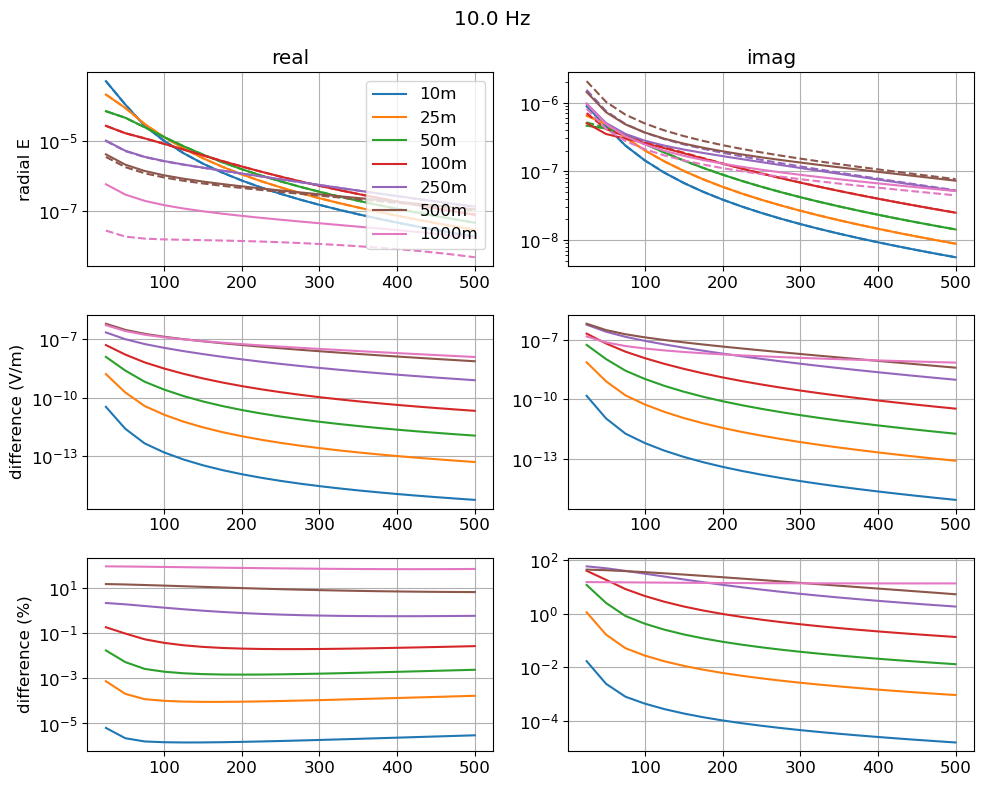

In [65]:
fig, ax = plt.subplots(3, 2, figsize=(10, 8))

freq = frequencies[14]
# print(freq)
for i, l in enumerate(casing_l):
    key0  = keys[i]
    keymu = keys[i+len(casing_l)]

    for j, comp in enumerate(["real", "imag"]):
        d0  = dobs_dict[key0][freq][f"{comp}_x"]
        dmu = dobs_dict[keymu][freq][f"{comp}_x"]
    
        ax[0, j].semilogy(rx_x, np.abs(d0), color=f"C{i}", label=f"{l}m")
        ax[0, j].semilogy(rx_x, np.abs(dmu), f"--C{i}")
        ax[1, j].semilogy(rx_x, np.abs(dmu-d0), f"-C{i}")
        ax[2, j].semilogy(rx_x, np.abs(dmu-d0)/np.abs(d0)*100, f"C{i}")
    
        ax[0, j].set_title(comp)

ax[0, 0].set_ylabel("radial E")
ax[1, 0].set_ylabel("difference (V/m)")
ax[2, 0].set_ylabel("difference (%)")
for a in ax.flatten():
    a.grid()

fig.suptitle(f"{freq:1.1f} Hz")
ax[0,0].legend()
plt.tight_layout()

In [46]:
def get_amplitude_phase(real, imag):
    # real = f.real
    # imag = f.imag
    amplitude = np.sqrt(real**2 + imag**2)
    phase = 180/np.pi*np.arctan2(imag, real)
    return amplitude, phase

In [ ]:
# fig, ax = plt.subplots(len(frequencies), 2, figsize=(10, len(frequencies)*3), sharex=True)

# key_ind = 0
# key = keys[key_ind]

# for i, freq in enumerate(frequencies): 
#     amp, phase = get_amplitude_phase(*(dobs_dict[key][freq][component].reshape((len(rx_x), len(rx_z)), order="F").T for component in ["real", "imag"]))
#     for j, plotme in enumerate([np.log10(np.abs(amp)), phase]): 
#         plt.colorbar(
#             ax[i, j].contourf(
#                 rx_x, rx_z, plotme, 30,
#                 # vmin=-7, vmax=-2
#                 # norm=LogNorm()
#                 cmap = "twilight" if j == 1 else "viridis"
#             ), ax=ax[i, j]
#         )
        
#         ax[i, j].plot(rx_e_re.locations[:, 0], rx_e_re.locations[:, 2], "w.", ms=1)
#         ax[i, j].set_aspect(1)
#         ax[i, j].set_title(f"{freq} Hz {'amplitude' if j==0 else 'phase'}")

# plt.tight_layout()


# set up mappings and simulation

In [ ]:
def create_maps(key, true_inds=False, casing_t_ind=0):
    indsx = (mesh.cell_centers[:, 0] < casing_b)
    if true_inds is True: 
        indsx = indsx & (mesh.cell_centers[:, 0] > casing_b - casing_t[casing_t_ind])
    
    inds_interior = (
        indsx &
        (mesh.cell_centers[:, 2] <= 0) &
        (mesh.cell_centers[:, 2] >= -casing_l)
    )

    active_inds_sigma = maps.InjectActiveCells(
        mesh, indActive=inds_interior, 
        valInactive=np.log(models[key]["sigma"][~inds_interior])
    )

    active_inds_mur = maps.InjectActiveCells(
        mesh, indActive=inds_interior, 
        valInactive=models[key]["mur"][~inds_interior]
    )

    projection_sigma = maps.SurjectUnits(indices=[np.ones(inds_interior.sum(), dtype=bool)])
    projection_mu = maps.SurjectUnits(indices=[np.ones(inds_interior.sum(), dtype=bool)])

    exp_map = maps.ExpMap(mesh)
    mur_map = maps.MuRelative(mesh)

    sigma_map = exp_map * active_inds_sigma * projection_sigma
    mu_map = mur_map * active_inds_mur * projection_mu

    return sigma_map, mu_map

In [ ]:
src_locations

In [ ]:
def create_survey(freq, components=["x"]): 
    rx_ex_re, rx_ex_im, rx_ez_re, rx_ez_im = create_receivers()
    rx_list = []
    if "x" in components: 
        rx_list.append([rx_ex_re, rx_ex_im])
    if "z" in components: 
        rx_list.append([rx_ez_re, rx_ez_im])
    src = fdem.sources.LineCurrent(list(np.hstack(rx_list)), location=src_locations, frequency=freq)
    return fdem.Survey([src])

In [ ]:
# create the simulation
def create_simulation(key, survey, invert_mu=False, true_inds=False):
    sigma_map, mu_map = create_maps(key, true_inds)

    if invert_mu is True: 
        wires = maps.Wires(("sigma", 1), ("mu", 1))
        sim = fdem.simulation.Simulation3DMagneticField(
            mesh, survey=survey, solver=Pardiso, 
            sigmaMap=sigma_map * wires.sigma,
            muMap=mu_map * wires.mu 
        )
    else: 
        sim = fdem.simulation.Simulation3DMagneticField(
            mesh, survey=survey, solver=Pardiso, 
            sigmaMap=sigma_map
        )
    return sim


In [ ]:
t = casing_t
sigdc = sigma_casing * (1-(casing_b-t)**2/casing_b**2)

data0 = {}
res0 = {}
rms0 = {}

components = ["x", "z"]

for i, key in enumerate(keys): 
    data_tmp = {}
    res_tmp = {}
    rms_tmp = {}
    
    for freq in frequencies: 
        survey = create_survey(freq, components)
    
        receivers = []
        if "x" in components: 
            receivers.append(["real_x", "imag_x"])
        if "z" in components: 
            receivers.append(["real_z", "imag_z"])
        dobsvec = np.hstack([dobs_dict[key][freq][rx] for rx in np.hstack(receivers)])
    
        sim = create_simulation(key, survey, invert_mu=False)
        dpred = sim.dpred(np.log(sigdc[i]))

        data_tmp[freq] = dpred
        res_tmp[freq] = dpred - dobsvec
        rms_tmp[freq] = np.sqrt(np.sum(res_tmp[freq]**2) / len(res_tmp[freq]))
    data0[key] = data_tmp
    res0[key] = res_tmp
    rms0[key] = rms_tmp

In [ ]:
fig, ax = plt.subplots(2, 1)

freq = frequencies[14]
print(freq)
for i, key in enumerate(keys): 
    dobs = dobs_dict[key][freq]["real_x"][:len(rx_x)]
    d0 = data0[key][freq][:len(rx_x)]
    ax[0].semilogy(rx_x, np.abs(dobs), color=f"C{i}", label=key)
    ax[0].semilogy(rx_x, np.abs(d0), f"--C{i}")
    ax[0].semilogy(rx_x, np.abs(d0-dobs), f":C{i}")

    ax[1].plot(rx_x, np.abs(d0-dobs)/np.abs(dobs)*100, f"C{i}")

# set up inversions

In [ ]:
class SaveInversionProgress(directives.InversionDirective):
    """
    A custom directive to save items of interest during the course of an inversion
    """
    
    results_file = None
    
    def initialize(self):
        """
        This is called when we first start running an inversion
        """
        # initialize an empty dictionary for storing results 
        self.inversion_results = {
            "iteration":[],
            "phi_d":[],
            "dpred":[],
            "logsigma":[],
            "residual":[],
            "rms":[],
            # "mur":[]
        }

    def endIter(self):
        """
        This is run at the end of every iteration. So here, we just append 
        the new values to our dictionary
        """
        
        # Save the data
        self.inversion_results["iteration"].append(self.opt.iter)
        self.inversion_results["phi_d"].append(self.invProb.phi_d)
        self.inversion_results["dpred"].append(self.invProb.dpred)
        
        dobs = self.invProb._dmisfit.objfcts[0].data.dobs
        
        self.inversion_results["residual"].append((dobs - self.invProb.dpred))
        self.inversion_results["rms"].append(np.sqrt(np.sum(self.inversion_results["residual"][-1]**2)/len(dobs)))
        self.inversion_results["logsigma"].append(self.invProb.model[0])
        # self.inversion_results["mur"].append(self.invProb.model[0])
        
        if self.results_file is not None: 
            with open(f"{self.results_file}", "wb") as fp:
                pickle.dump(self.inversion_results, fp)
        
        

In [ ]:
tmp = []
tmp.append(["a", "b"])
np.hstack(tmp)

In [ ]:
def create_inversion(
    key, freq, invert_mu=False, relative_error=None, noise_floor=None,
    maxIter=10, maxIterCG=50, maxIterLS=10, true_casing_inds=False, components=["x"]
):
    # create the simulation
    survey = create_survey(freq, components)

    receivers = []
    if "x" in components: 
        receivers.append(["real_x", "imag_x"])
    if "z" in components: 
        receivers.append(["real_z", "imag_z"])
    dobsvec = np.hstack([dobs_dict[key][freq][rx] for rx in np.hstack(receivers)])
    dobs = data.Data(
        survey=survey, dobs=dobsvec, relative_error=relative_error, noise_floor=noise_floor
    )

    sim = create_simulation(key, survey, invert_mu, true_casing_inds)
    dmis = data_misfit.L2DataMisfit(data=dobs, simulation=sim)

    if invert_mu is True: 
        reg = regularization.Smallness(mesh=discretize.TensorMesh([2]))
        opt = optimization.ProjectedGNCG(
            maxIter=maxIter, lower=np.r_[-np.inf, 1], 
            maxIterCG=maxIterCG, maxIterLS=maxIterLS,
            # aggressive_stepping=True
            # tolF=1e-3, tolX=1e-3,
        )
        # opt = optimization.InexactGaussNewton(
        #     maxIter=maxIter, #lower=np.r_[-np.inf, 1], 
        #     maxIterCG=maxIterCG, maxIterLS=maxIterLS,
        #     aggressive_stepping=True
        #     # tolF=1e-3, tolX=1e-3,
        # )
    else: 
        reg = regularization.Smallness(mesh=discretize.TensorMesh([1]))
        opt = optimization.ProjectedGNCG(
            maxIter=maxIter, lower=np.r_[-np.inf], 
            maxIterCG=maxIterCG, maxIterLS=maxIterLS,
            # aggressive_stepping=True
            # tolF=1e-3, tolX=1e-3,
        )
        # opt = optimization.InexactGaussNewton(
        #     maxIter=maxIter, #lower=np.r_[-np.inf, 1], 
        #     maxIterCG=maxIterCG, maxIterLS=maxIterLS,
            # aggressive_stepping=True
        #     # tolF=1e-3, tolX=1e-3,
        # )

    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt, beta=0)

    # directives
    target_misfit = directives.TargetMisfit(chifact=0.5)
    
    if true_casing_inds:
        filename_save = f"inv_{key}_{freq:1.0f}_true_casing.pkl"
    else: 
        filename_save = f"inv_{key}_{freq:1.0f}.pkl"
    inversion_progress = SaveInversionProgress(results_file=f"{directory_path}/{filename_save}")
    
    # inversion 
    inv = inversion.BaseInversion(inv_prob, [target_misfit, inversion_progress])
    
    return inv

# experiment 2: invert for solid cylinder conductivity, permeability 

In [ ]:
keys

In [ ]:
models.keys()

In [ ]:
inv_dict = {}
relative_error = 0.005
noise_floor = 1e-8

for key in keys:
    if key not in inv_dict: 
        tmp = {}
        for freq in frequencies:
            tmp[freq] = create_inversion(
                    key, freq, invert_mu=False, relative_error=relative_error, noise_floor=noise_floor,
                    components=["x", "z"]
                )
        inv_dict[key] = tmp

In [ ]:
t = casing_t
sigdc = sigma_casing * (1-(casing_b-t)**2/casing_b**2)
# starting_models = {
#     True: np.r_[np.log(sigstart), 1],
#     False: np.r_[np.log(sigstart)]
# }
sigdc

In [ ]:
sigdc

In [ ]:
mrec_dict = {}

for i, key in enumerate(keys):
    if key not in mrec_dict: 
        tmp = {}
        for freq in frequencies:
            print(f"\n\n------------------------ {key} : {freq} Hz -------------------------- \n")

            # if skin_depth(freq, sigma_casing[i], 1) < casing_b: 
            #     mstart = np.log(sigdc[i])
            # else:
            #     mstart = np.log(sigma_casing[i])

            # # mstart = (np.log(sigdc[i] + np.log(sigma_casing[i]))/2
            mstart = np.log(sigdc[i])
            # mstart = np.log(sigma_casing[i])
                
            tmp[freq] = inv_dict[key][freq].run(mstart) 
            print(f"recovered conductivity: {np.exp(inv_dict[key][freq].m[0]):1.2e} \n")
        mrec_dict[key] = tmp

In [ ]:
inv_results = {}

for key in keys:
    if key not in inv_results: 
        tmp = {}
        for freq in frequencies:
            tmp[freq] = inv_dict[key][freq].directiveList.dList[1].inversion_results
        inv_results[key] = tmp

In [ ]:
tmp = inv_results[keys[0]][frequencies[0]]

In [ ]:
tmp = inv_dict[keys[0]][frequencies[0]]

In [ ]:
phi_d_final = {}
chifact_final = {}
phid_star = len(rx_x)*len(rx_z)*2

for key in keys:
    phid_tmp = np.ones(len(frequencies)) * np.nan
    for i, freq in enumerate(frequencies): 
        phid = inv_results[key][freq]["phi_d"]
        if len(phid) > 0: 
            phid_tmp[i] = phid[-1]
    phi_d_final[key] = phid_tmp
    chifact_final[key] = phi_d_final[key] / phid_star

In [ ]:
phid_min = {}
chifact_min = {}
mrec_min = {}
rms_min = {}

for key in keys:
    phid_tmp = np.ones(len(frequencies)) * np.nan
    mrec_tmp = np.ones(len(frequencies)) * np.nan
    rms_tmp = np.ones(len(frequencies)) * np.nan
    for i, freq in enumerate(frequencies): 
        phid = inv_results[key][freq]["phi_d"]
        if len(phid) > 0: 
            ind_min = np.argmin(phid)
            phid_tmp[i] = phid[ind_min]
            mrec_tmp[i] = inv_results[key][freq]["logsigma"][ind_min]
            rms_tmp[i] = inv_results[key][freq]["rms"][ind_min]
    phid_min[key] = phid_tmp
    mrec_min[key] = mrec_tmp
    rms_min[key] = rms_tmp

In [ ]:
dpred_rec = {}
std_dict = {}

nlocs = len(rx_x)*len(rx_z)

for key in keys:
    tmp_dpred = {}
    tmp_std = {}
    for i, freq in enumerate(frequencies):
        dpred = inv_dict[key][freq].invProb.dpred
        std = inv_dict[key][freq].invProb.dmisfit.objfcts[0].data.standard_deviation
        
        tmp_dpred[freq] = {
            "real_x":dpred[:nlocs],
            "imag_x":dpred[nlocs:2*nlocs],
            "real_z":dpred[2*nlocs:3*nlocs],
            "imag_z":dpred[3*nlocs:]
        }

        tmp_std[freq] = {
            "real_x":std[:nlocs],
            "imag_x":std[nlocs:2*nlocs],
            "real_z":std[2*nlocs:3*nlocs],
            "imag_z":std[3*nlocs:]
        }
        
    dpred_rec[key] = tmp_dpred
    std_dict[key] = tmp_std

In [ ]:
fields_rec = {}

for key in keys:
    tmp_fields = {}
    for i, freq in enumerate(frequencies):
        tmp_fields[freq] = inv_dict[key][freq].invProb.dmisfit.objfcts[0].simulation.fields(mrec_min[key][i])
 
    fields_rec[key] = tmp_fields

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True) 

for key in keys: 
    ax[0].loglog(frequencies, phi_d_final[key], "o", label=key)
    ax[0].semilogx(frequencies, phid_star * np.ones_like(frequencies),"--k")
    ax[1].loglog(frequencies, np.exp(np.hstack(mrec_dict[key].values())), "o", label=key)
    # ax[1].loglog(frequencies, np.ones_like(frequencies)*sigma_casing, "--k")
    # ax[1].loglog(frequencies, np.ones_like(frequencies)*sigdc, "--k")
ax[1].legend()

<!-- 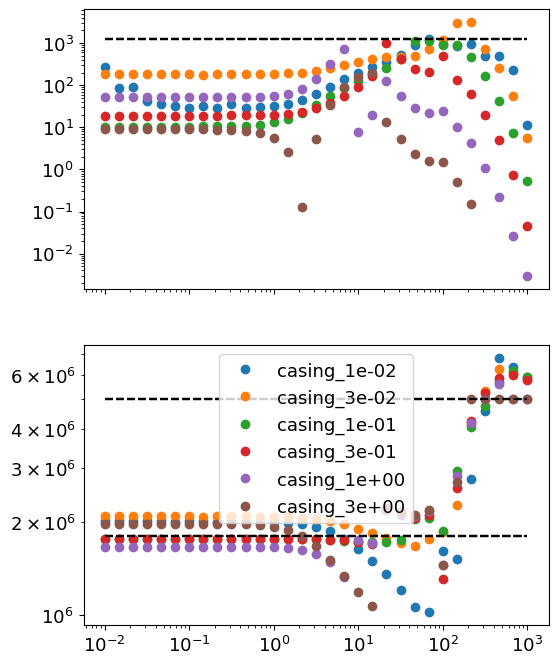 -->

In [ ]:
markers = ["s", "v", "o", "D", "p", "D", "h"]
colors = ["C5", "C6", "k", "C9"]

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6.5), sharex=True) #, dpi=dpi_high) 

for i, key in enumerate(keys): 
    label = f"{sigma_casing[i]:1.0e} S/m"
    ax[0].loglog(frequencies, rms_min[key], f"-{markers[i]}", color=colors[i], lw=0.75, ms=4, label=label)
    ax[1].loglog(frequencies, np.exp(mrec_min[key]), f"-{markers[i]}", color=colors[i], lw=0.75, ms=4, label=label)
    # ax[1].loglog(frequencies, sigdc[i+1]*np.ones_like(frequencies), "--", color=colors[i], alpha=0.5)
    # ax[1].loglog(frequencies, sigma_casing[i+1]*np.ones_like(frequencies), "--", color=colors[i], alpha=0.5)
    # sig_t = 500**2 / (casing_t**2 * frequencies)
    # ax[1].loglog(frequencies, sig_t, ":k", alpha=0.2)

sig_b = 500**2 / ((casing_b/2)**2 * frequencies)
ax[1].loglog(frequencies, sig_b, ":k", alpha=0.6)

ax[1].text(4e1, 1.2e7, "$\delta\sim r/2$", alpha=0.7)
# ax[1].text(2.3e2, 1.2e7, "$\delta\sim t$", alpha=0.7)
ax[0].legend(loc=2)

ax[0].set_ylabel("RMS Misfit (V/m)")
ax[1].set_ylabel("Recovered $\sigma$ (S/m)")
ax[1].set_xlabel("frequency (Hz)")
ax[1].set_ylim(6e4, 2e7)

ax[0].set_title("(a)")
ax[1].set_title("(b)")
for a in ax:
    a.grid()

plt.tight_layout()
    

<!-- 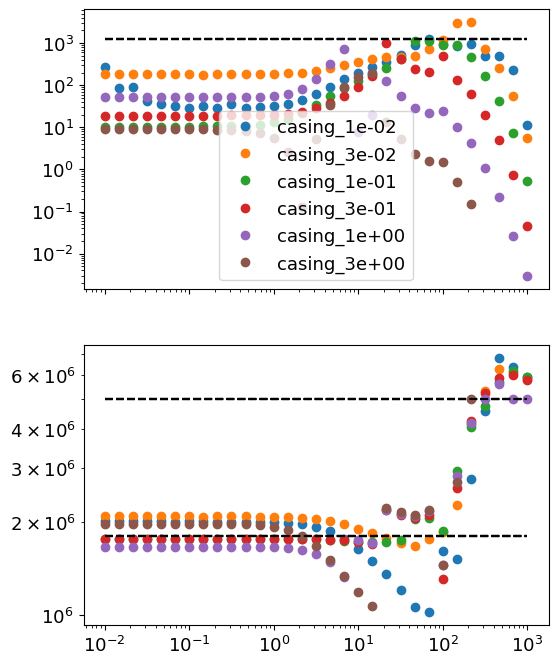 -->

In [ ]:
# plot the data

In [ ]:
def plot_data(data, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1)

    plt.colorbar(
        ax.contourf(
            rx_x, rx_z, data.reshape((len(rx_x), len(rx_z)), order="F").T, 30
        ),
        ax=ax
    )

    ax.plot(rx_ex_re.locations[:, 0], rx_ex_re.locations[:, 2], "w.", ms=1)
    ax.set_aspect(1)

    return ax

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(10, 12), sharex=True)

key_ind = 1
key = keys[key_ind]

freq = frequencies[1]
 
# ax.plot(rx_x, dobs_dict[key][freq]["real"].reshape((len(rx_x), len(rx_z)), order="F"), "o" );
for j, component in enumerate(["real_z", "imag_z"]): 
    pred = dpred_rec[key][freq][component]
    plot_data(pred, ax[0, j])
    
    diff = pred - dobs_dict[key][freq][component]
    plot_data(diff, ax[1, j])

    normalized_diff = np.abs(diff) / std_dict[key][freq][component] 
    plot_data(normalized_diff, ax[2, j])
    
    # ax[i, j].set_title(f"{freq} Hz {component}")

for a in ax.flatten():
    a.set_xlim(0, 600)
plt.tight_layout()


In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(10, 12), sharex=True)

key_ind = 0
key = keys[key_ind]

freq = frequencies[0]
 
# ax.plot(rx_x, dobs_dict[key][freq]["real"].reshape((len(rx_x), len(rx_z)), order="F"), "o" );
for j, component in enumerate(["real_z", "imag_z"]): 
    pred = dpred_rec[key][freq][component]
    plot_data(np.log10(np.abs(pred)), ax[0, j])
    
    diff = pred - dobs_dict[key][freq][component]
    plot_data(np.log10(np.abs(diff)), ax[1, j])

    normalized_diff = np.abs(diff) / std_dict[key][freq][component] 
    plot_data(np.log10(np.abs(normalized_diff)), ax[2, j])
    
    # ax[i, j].set_title(f"{freq} Hz {component}")

plt.tight_layout()


In [ ]:
def plot_fields(
    field_plot, freq_ind=0, xlim=500*np.r_[-1, 1], zlim=np.r_[-1000, 10], component="real", ax=None, vmin=None, vmax=None, aspect=True,
    plot_source=False
):
    if ax is None: 
        fig, ax = plt.subplots(1,1)

    field_plot = mesh.average_face_to_cell_vector * np.squeeze(field_plot)
    
    out = mesh.plot_image(
        getattr(field_plot, component), "CCv", view="vec", 
        range_x = xlim, range_y = zlim,
        sample_grid = np.r_[np.diff(xlim)/100, np.diff(zlim)/100],
        mirror=True, #mirror_data=field_mirror,
        ax=ax, 
        pcolor_opts={"norm":LogNorm(vmin=vmin, vmax=vmax)},
        stream_threshold=vmin
    )

    if plot_source is True: 
        ax.plot(src_locations[:, 0], src_locations[:, 2], "w", lw=2)
    
    cb = plt.colorbar(out[0], ax=ax)
    # cb.set_label("Electric Field (V/m)")
    if aspect is True:
        ax.set_aspect(1)

    return out, cb

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

key = keys[0]
freq_ind = 10

aspect = False
xlim = 50*np.r_[-1, 1]
zlim = np.r_[-550, 0] 
plot_source = True
vmin=1e-8

true_fields = fields[key]
fields_true = true_fields[true_fields.simulation.survey.source_list[freq_ind], "e"]
plot_fields(fields_true, component="real", ax=ax[0, 0], aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
plot_fields(fields_true, component="imag", ax=ax[1, 0], aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)

fields_pred = fields_rec[key][frequencies[freq_ind]][:, "e"]

fields_diff = fields_true - fields_pred
plot_fields(fields_diff, component="real", ax=ax[0, 1], vmin=vmin, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
plot_fields(fields_diff, component="imag", ax=ax[1, 1], vmin=vmin, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)


plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 1) 
for key in keys: 
    max_diff = np.hstack([np.max(np.abs(res0[key][f]))for f in frequencies])
    ax.loglog(frequencies, max_diff, "o", label=key)

In [ ]:
500/np.sqrt(sigma_casing * 2) 

In [ ]:
casing_t

In [ ]:
skin_depths_casing = 500/np.sqrt(np.outer(sigma_casing,frequencies)).T

fig, ax = plt.subplots(1, 1) 
ax.loglog(frequencies, skin_depths_casing)
ax.loglog(frequencies, np.ones_like(frequencies)*casing_t, "--k")
ax.loglog(frequencies, np.ones_like(frequencies)*csz, ":k")

In [ ]:
x_data = mesh.nodes_x[31]
data_locs = np.hstack([mesh.faces_x[:, 0] == x_data, np.zeros(mesh.n_faces_z, dtype=bool)])
np.sum(data_locs)

In [ ]:
frequencies[14]

In [ ]:
keys

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(12, 10), sharey=True)

key = keys[2]
freq_ind = 27

aspect = False
xlim = 0.08*np.r_[0, 1]
zlim = np.r_[-550, 0] 
plot_source = True
vmin=1e-8
vmax=1e1

true_fields = fields[key]
fields_true = true_fields[true_fields.simulation.survey.source_list[freq_ind], "j"]
plot_fields(fields_true, component="real", ax=ax[0, 0], vmin=vmin, vmax=vmax, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
plot_fields(fields_true, component="imag", ax=ax[1, 0], vmin=vmin, vmax=vmax, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
ax[0, 0].set_title("Real, Hollow")
ax[1, 0].set_title("Imag, Hollow")


fields_pred = fields_rec[key][frequencies[freq_ind]][:, "j"]
plot_fields(fields_pred, component="real", ax=ax[0, 1], vmin=vmin, vmax=vmax, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
plot_fields(fields_pred, component="imag", ax=ax[1, 1], vmin=vmin, vmax=vmax, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
ax[0, 1].set_title("Real, Solid")
ax[1, 1].set_title("Imag, Solid")

for i, component in enumerate(["real", "imag"]):
    ax[i, 2].semilogx(np.abs(getattr(fields_true[data_locs], component)), mesh.cell_centers_z, ".", ms=3, label="hollow")
    ax[i, 2].semilogx(np.abs(getattr(fields_pred[data_locs], component)), mesh.cell_centers_z, ".", ms=3, label="solid")
    ax[i, 2].semilogx(np.abs(getattr(fields_pred[data_locs] - fields_true[data_locs], component)), mesh.cell_centers_z, ".", ms=3, label="diff")
    ax[i, 2].set_ylim(zlim)
    ax[i, 2].set_xlim(np.r_[vmin, vmax*1e-2])
    ax[i, 2].grid()
    ax[i, 2].set_title(f"j$_x$ {component} at {x_data:1.2f}m")
    ax[i, 2].set_xlabel("j$_x$ (A/m$^2$)")

ax[0, 2].legend(loc=1)
fig.suptitle(f"{key.split('_')[1][3:]}S/m, {key.split('_')[-1][3:]} $\mu_0$, {frequencies[freq_ind]:1.1e} Hz, rms: {rms_min[key][freq_ind]:1.1e} V/m")

# fields_diff = fields_true - fields_pred
# plot_fields(fields_diff, component="real", ax=ax[0, 1], vmin=vmin, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
# plot_fields(fields_diff, component="imag", ax=ax[1, 1], vmin=vmin, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)


plt.tight_layout()

In [ ]:
# key = "casing_1_1.00e-02"
# freq = frequencies[freq_inds_inv[0]]

# plot_obs_pred(key, freq, False);